# Titanic Dataset from Kaggle
_<span style='color:darkred'>To show some plots, I've used kaggle's <a href='https://www.kaggle.com/c/titanic'>Titanic dataset</a>._   
_<span style='color:darkred'>Also, thanks to <a href='https://www.kaggle.com/ldfreeman3'>LD Freeman</a> for his notebook <a href='https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy'>A Data Science Framework: To Achieve 99% Accuracy</a> on data preprocessing and model selection._

In [1]:
import pandas as pd
import numpy as np

In [2]:
def load_kaggle_data(filename) :
    data_folder = "./data/titanic/"
    data = pd.read_csv(data_folder + filename + ".csv")
    return data

df_train = load_kaggle_data('train')
df_test = load_kaggle_data('test')

In [3]:
def handle_missing_data(dataset) : 
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    drop_columns = ['PassengerId','Cabin', 'Ticket']
    dataset.drop(drop_columns, axis=1, inplace = True)
    return dataset

df_train = handle_missing_data(df_train)
df_test = handle_missing_data(df_test)

In [4]:
for dataset in [df_train, df_test]:    
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1 
    dataset.loc[dataset['FamilySize'] > 1, 'IsAlone'] = 0
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
stat_min = 10
title_names = (pd.concat([df_train['Title'] ,df_test['Title']]).value_counts() < stat_min)
df_train['Title'] = df_train['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
df_test['Title'] = df_test['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [5]:
for dataset in [df_train, df_test]:    
    dataset['Sex_Code']      = dataset['Sex'].astype('category').cat.codes
    dataset['Embarked_Code'] = dataset['Embarked'].astype('category').cat.codes
    dataset['Title_Code']    = dataset['Title'].astype('category').cat.codes
    dataset['AgeBin_Code']   = dataset['AgeBin'].astype('category').cat.codes
    dataset['FareBin_Code']  = dataset['FareBin'].astype('category').cat.codes
label_col = ['Survived']
feat_cols = ['Sex','Pclass', 'Embarked', 'Title', 'FamilySize', 'AgeBin', 'FareBin']
code_cols = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']

In [6]:
np.random.seed(42)
split_idx = np.random.choice([0, 1], size=len(df_train), p=[.3, .7]).astype(bool)
data_train = df_train[split_idx]
data_valid = df_train[~split_idx]

In [7]:
%matplotlib inline

import radtree

from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, feature_selection
from sklearn import datasets

from matplotlib import MatplotlibDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

# Overfit

In [8]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(data_train[code_cols], data_train[label_col].values.ravel())

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

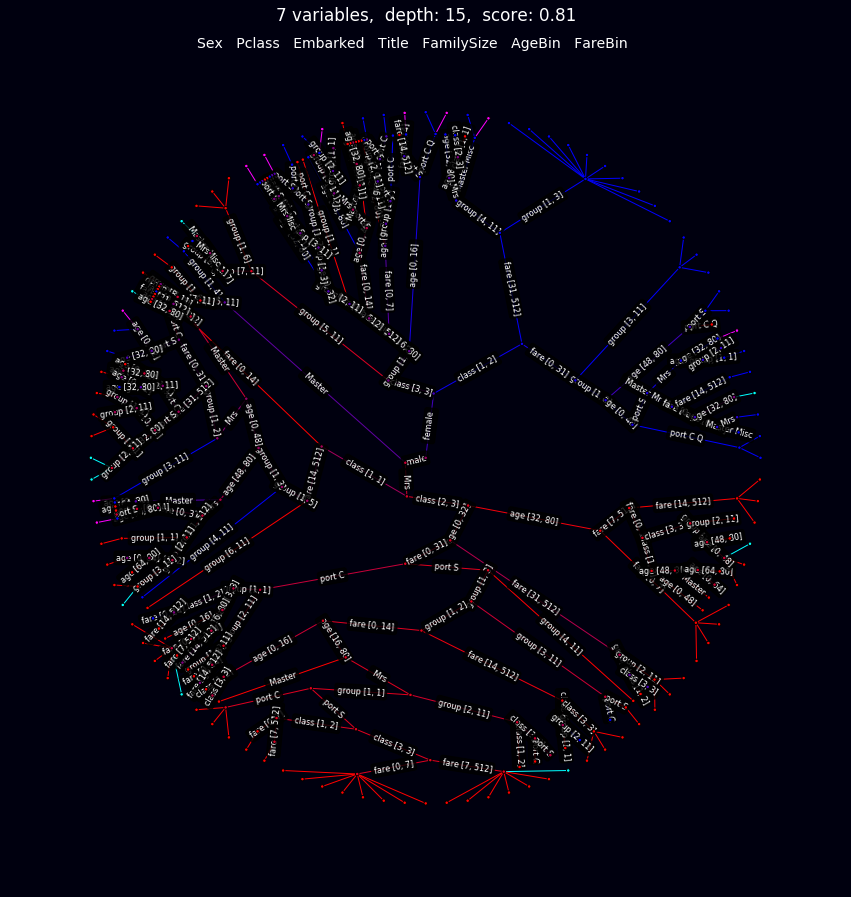

In [9]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=feat_cols, label_col=label_col,
                    random_seed=42,
                    tiny_names=['', 'class', 'port', '', 'group', 'age', 'fare'], 
                    l_alpha=.2, l_width=1
                   )

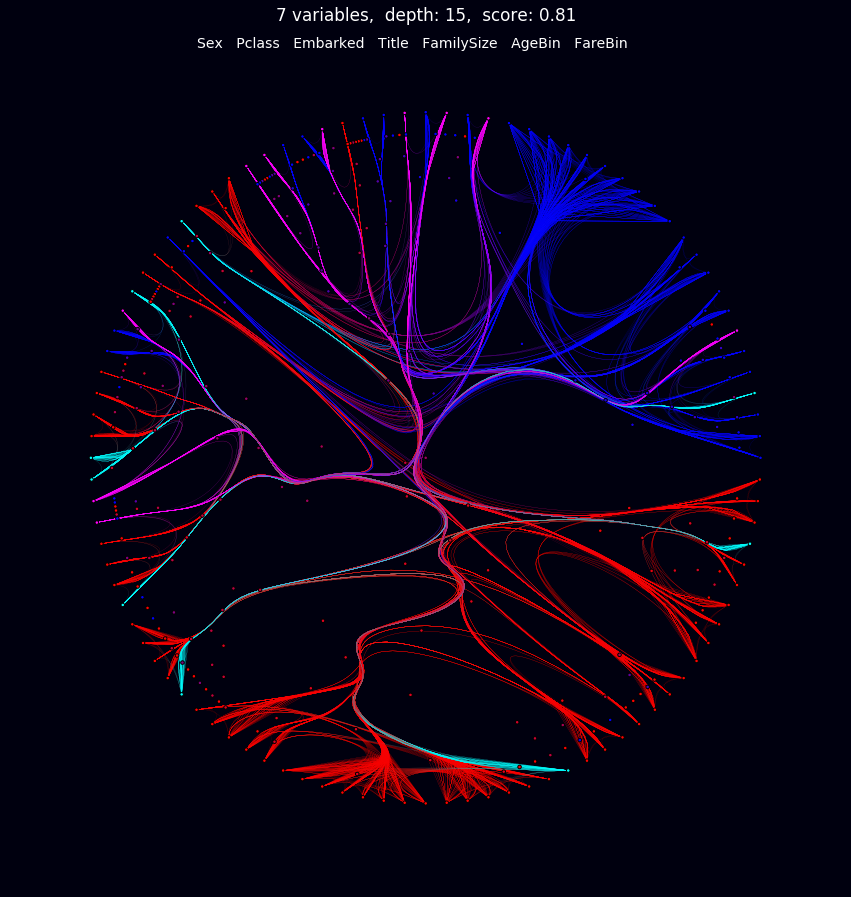

In [10]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=feat_cols, label_col=label_col,
                    smooth_d=8, l_alpha=.5, l_width=.2, random_seed=42)

# Feature Selection

In [11]:
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=42)
dtree = DecisionTreeClassifier()
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data_train[code_cols], data_train[label_col].values.ravel())
sel_features = data_train[code_cols].columns.values[dtree_rfe.get_support()]
sel_features_cat = [s.split('_')[0] for s in sel_features]
dtree = DecisionTreeClassifier()
dtree.fit(data_train[sel_features], data_train[label_col])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

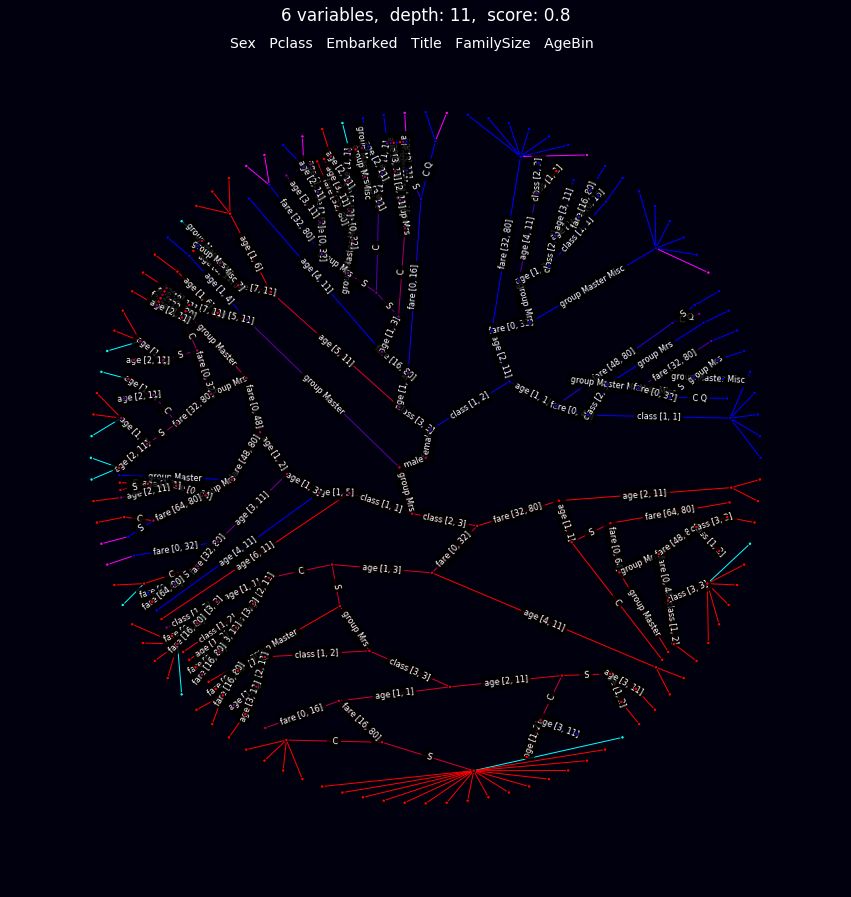

In [12]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col,
                    random_seed=42,
                    tiny_names=['', 'class', '', 'group', 'age', 'fare'], 
                    l_alpha=.2, l_width=1
                   )

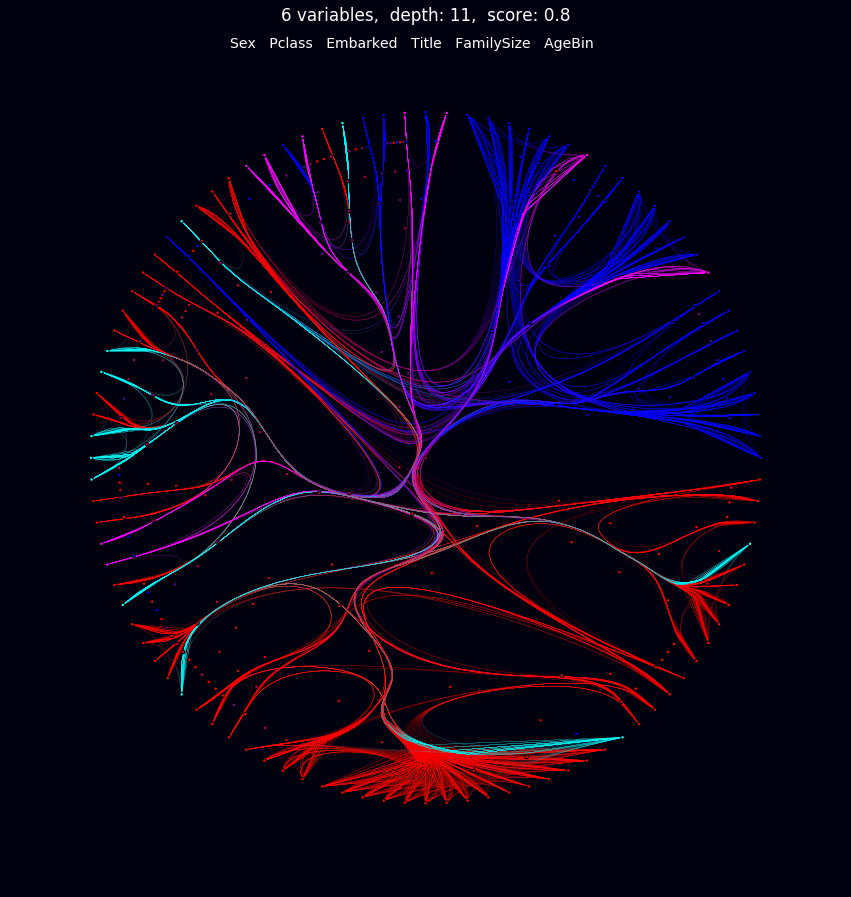

In [13]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col,
                    smooth_d=8, l_alpha=.5, l_width=.2, random_seed=42)

# Grid Search CV

In [14]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2,4,6,8,10,None],
              'random_state': [42],
              'splitter': ['best', 'random'],
              #'min_samples_split': [2,5,10,.03,.05],
              #'min_samples_leaf': [1,5,10,.03,.05], 
              'max_features': [None, 'auto'],
             }
dtree_gscv = model_selection.GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring = 'accuracy', cv = cv_split)
dtree_gscv.fit(data_train[sel_features], data_train[label_col])
dtree = dtree_gscv.best_estimator_

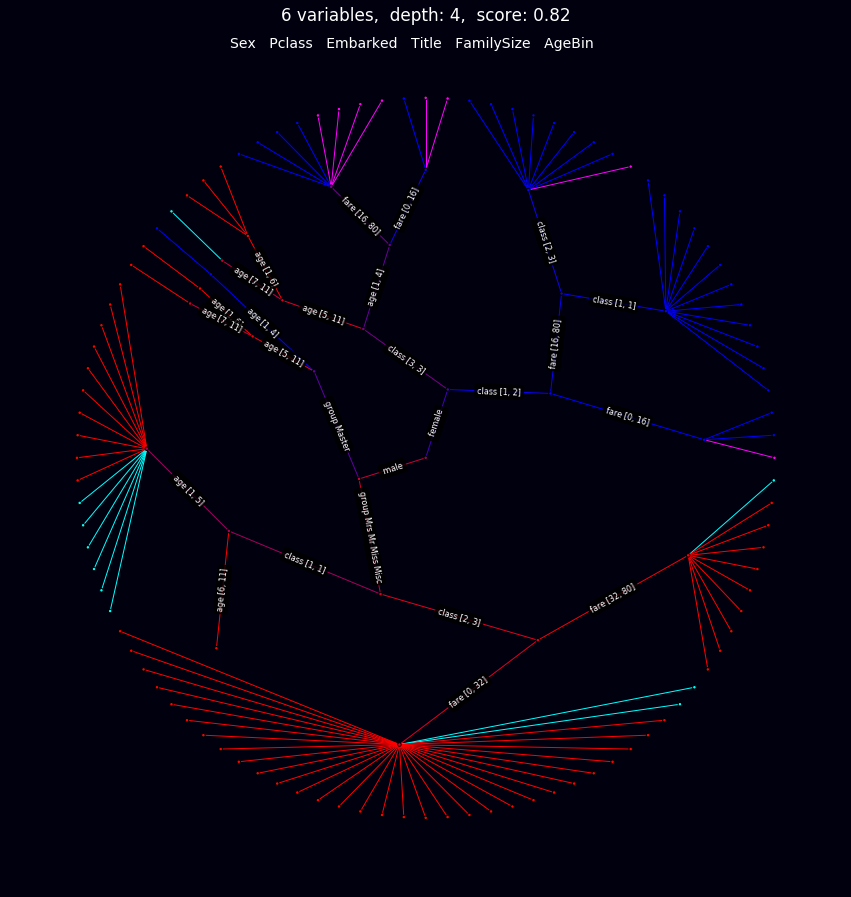

In [15]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col, 
                    l_alpha=.2, l_width=1, random_seed=42,
                    tiny_names=['', 'class', '', 'group', 'age', 'fare'])

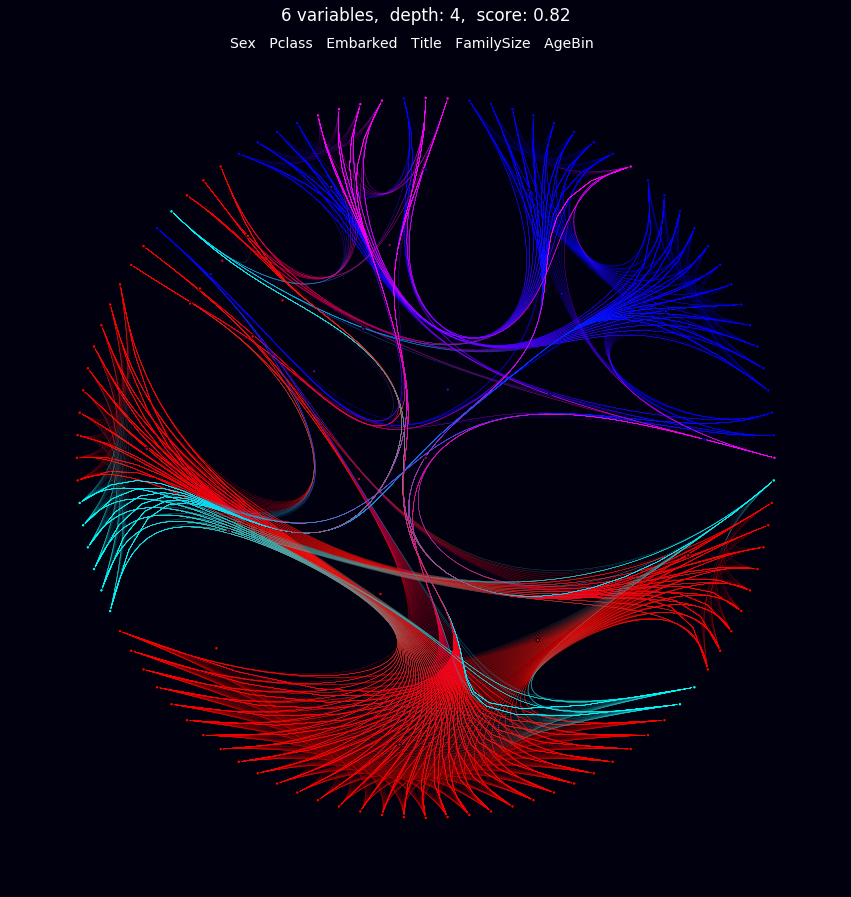

In [16]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col, 
                    smooth_d=8, l_alpha=.5, l_width=.2, random_seed=42)

# Other plots

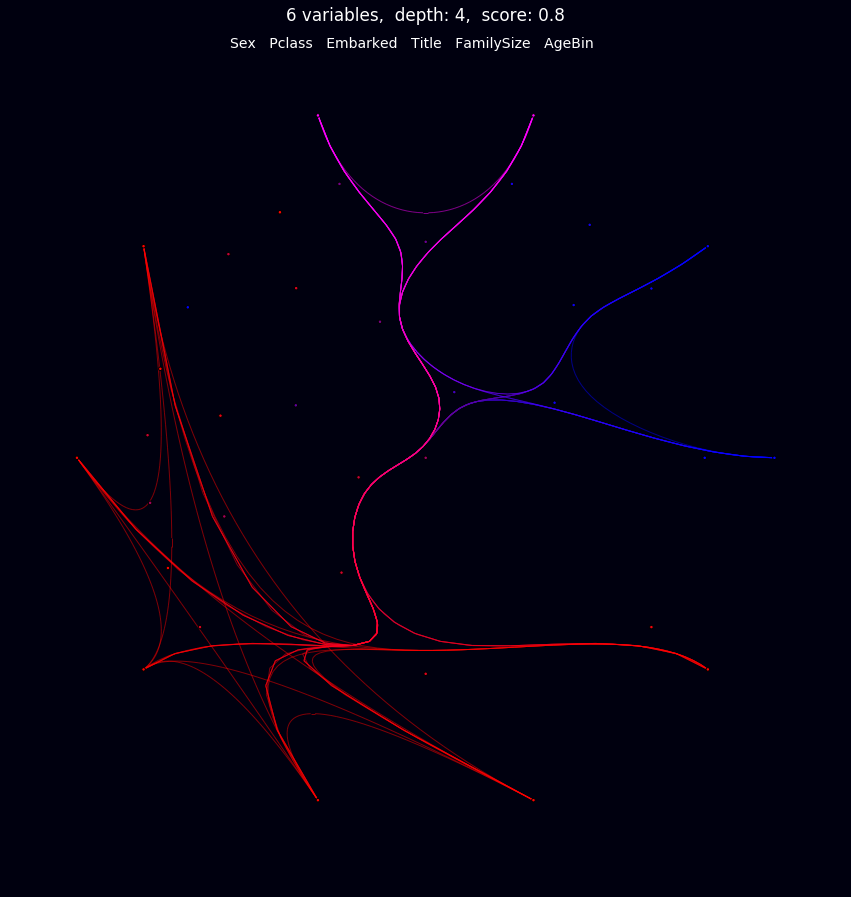

In [17]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col, 
            num_samples=10, smooth_d=3, l_alpha=.5, l_width=1, random_seed=4321)

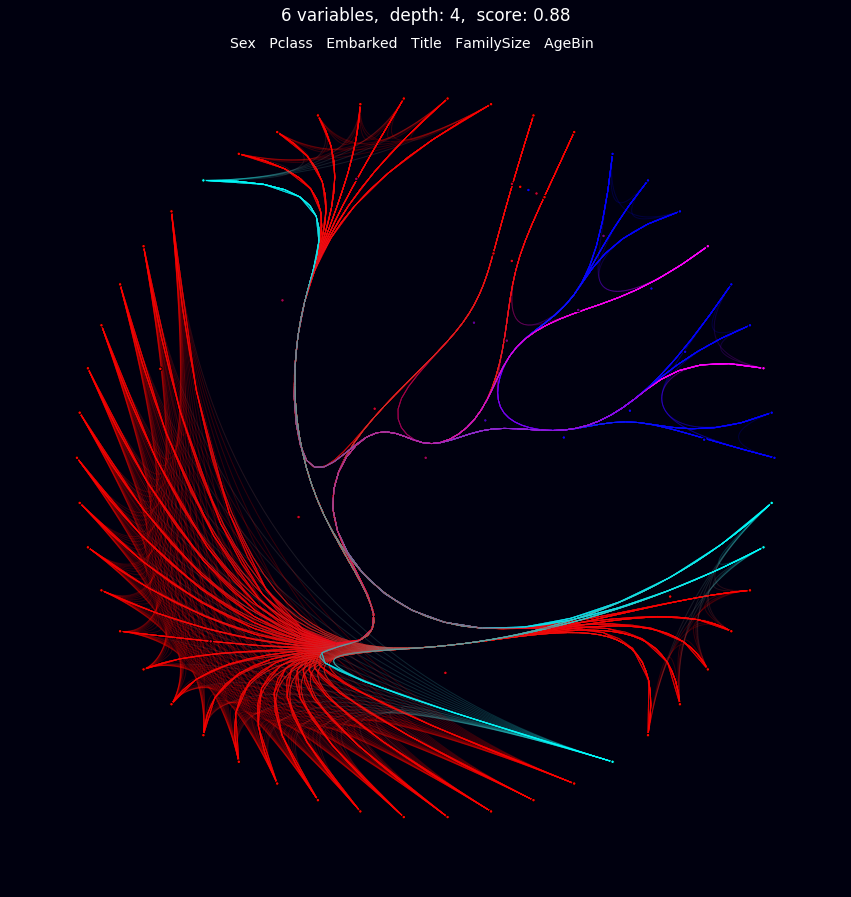

In [18]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col, 
            num_samples=50, smooth_d=3, l_alpha=.2, l_width=1, random_seed=33)

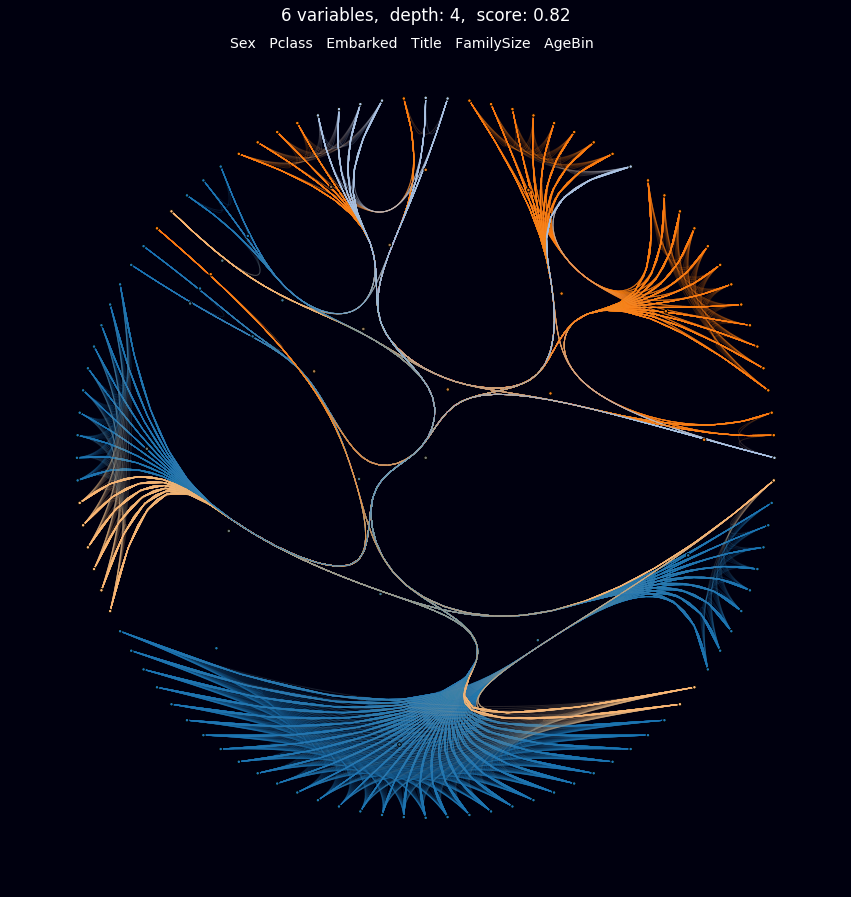

In [19]:
radtree.plot_radial(dtree, data=data_valid, feature_cols=sel_features_cat, label_col=label_col, 
            cmap='tab20', num_samples=100, smooth_d=3, l_alpha=.2, l_width=1, random_seed=42)

# Plot PCA

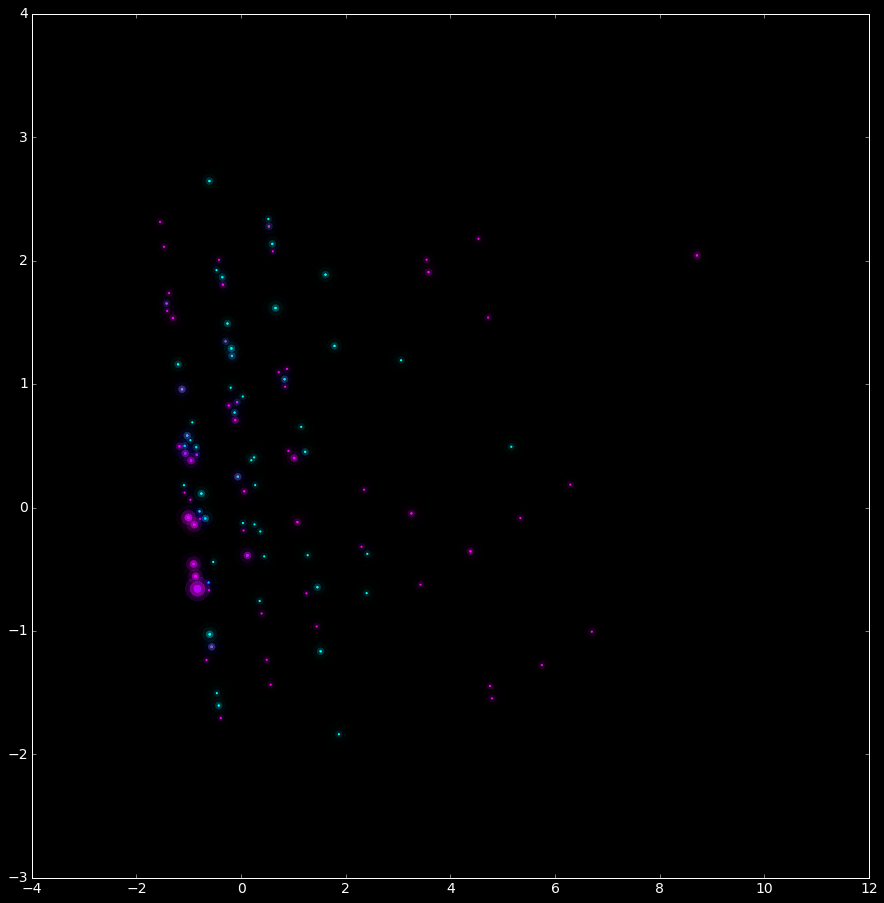

In [20]:
radtree.plot_pca(data_train[sel_features], data_train[label_col].values, 
                  validation_data=(data_valid[sel_features], data_valid[label_col].values))

# Plot UMAP

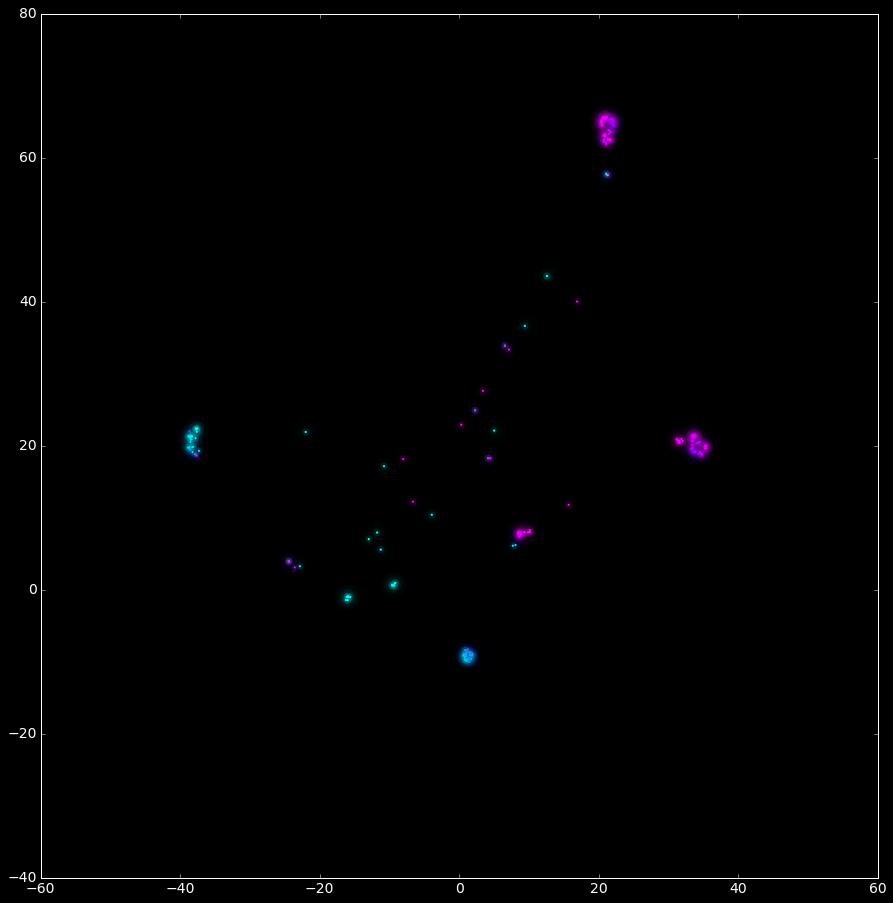

In [21]:
radtree.plot_umap(data_train[sel_features], data_train[label_col].values, 
                  validation_data=(data_valid[sel_features], data_valid[label_col].values))

# Plot TSNE

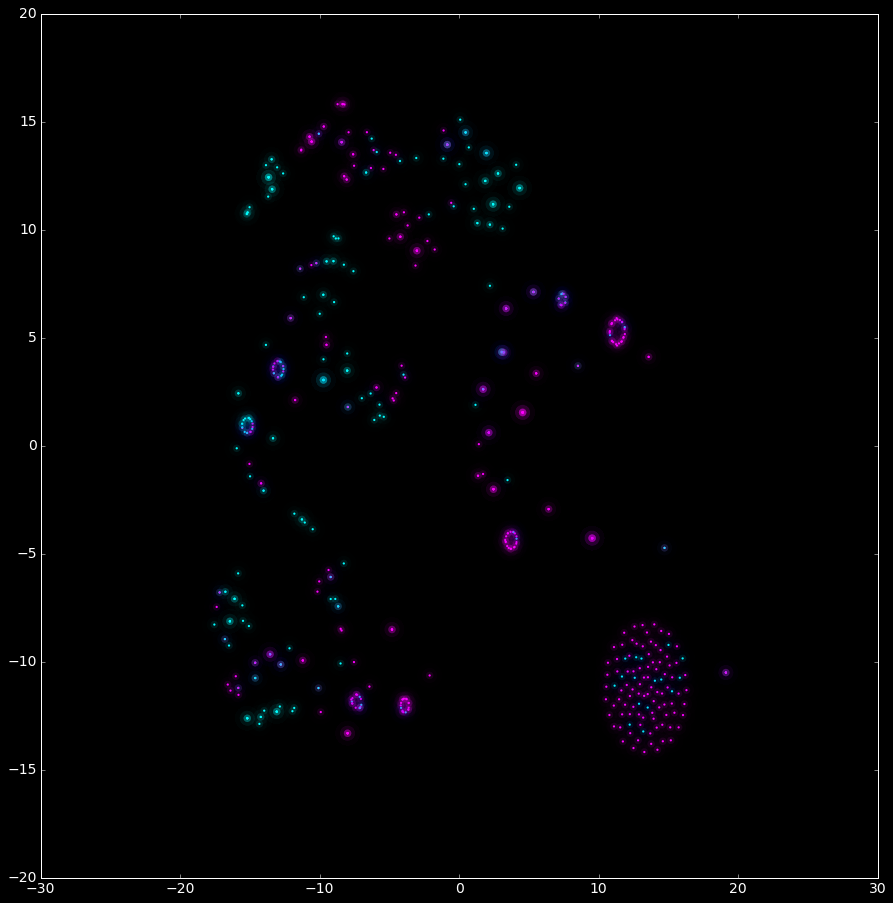

In [22]:
radtree.plot_tsne(data_train[sel_features], data_train[label_col].values)